In [1]:
%cd /content/drive/MyDrive/Fall 2023/Deep Learning/Final/
%pip install keras-tcn -q

/content/drive/MyDrive/Fall 2023/Deep Learning/Final
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.4 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from enum import Enum
from tcn import compiled_tcn, TCN

In [3]:
class FileData:
    def __init__(
        self,
        name,
        acc_index,
        vel_index,
        dsp_index,
        lst_index,
        dt_acc,
        dt_vel,
        dt_dsp,
        unit_acc,
        unit_vel,
        unit_dsp,
        acc_values,
        vel_values,
        dsp_values,
        dt_sampling,
        acc_values_sampled,
        vel_values_sampled,
        dsp_values_sampled,
    ):
        self.name = name
        self.acc_index = acc_index
        self.vel_index = vel_index
        self.dsp_index = dsp_index
        self.lst_index = lst_index
        self.dt_acc = dt_acc
        self.dt_vel = dt_vel
        self.dt_dsp = dt_dsp
        self.unit_acc = unit_acc
        self.unit_vel = unit_vel
        self.unit_dsp = unit_dsp
        self.acc_values = acc_values
        self.vel_values = vel_values
        self.dsp_values = dsp_values
        self.dt_sampling = dt_sampling
        self.acc_values_sampled = acc_values_sampled
        self.vel_values_sampled = vel_values_sampled
        self.dsp_values_sampled = dsp_values_sampled
        self.ID = 0
        self.u_r = None
        self.ud_r = None
        self.udd_r = None
        self.t = None  # time vector

    def __str__(self) -> str:
        return f"{self.name, self.acc_index, self.vel_index, self.dsp_index, self.lst_index, self.dt_acc, self.dt_dsp, self.unit_acc, self.unit_vel, self.unit_dsp, self.acc_values, self.vel_values, self.dsp_values, self.dt_sampling, self.acc_values_sampled, self.vel_values_sampled, self.dsp_values_sampled, self.ID, self.u_r, self.ud_r, self.udd_r, self.t}"

    def __repr__(self) -> str:
        return self.__str__()

In [4]:
class NormalizationOption(Enum):
    NoScaling = 0
    ScaleShiftStandard = 1
    ScaleShiftAll = 2
    ScaleAll = 3
    ScaleFeatureBased = 4

class TensorsType(Enum):
    Tensorflow = 0
    Torch = 1

class Dataset:
    def __init__(self, filename: str, normalizationOption: NormalizationOption):
      self.data = np.asarray(pd.read_pickle(filename), dtype=object)
      self.normalizationOption = normalizationOption

      self.max_timesteps = max(len(file_data.acc_values_sampled) for file_data in self.data)
      self.min_timesteps = min(len(file_data.acc_values_sampled) for file_data in self.data)

      self.max_abs_acc_input  = max(np.absolute(file_data.acc_values_sampled).max() for file_data in self.data)
      self.max_abs_acc_output = max(np.absolute(file_data.udd_r).max() for file_data in self.data)
      self.max_abs_vel_output = max(np.absolute(file_data.ud_r).max() for file_data in self.data)
      self.max_abs_dsp_output = max(np.absolute(file_data.u_r).max() for file_data in self.data)

      self.max_acc_input  = max(file_data.acc_values_sampled.max() for file_data in self.data)
      self.max_acc_output = max(file_data.udd_r.max() for file_data in self.data)
      self.max_vel_output = max(file_data.ud_r.max() for file_data in self.data)
      self.max_dsp_output = max(file_data.u_r.max() for file_data in self.data)

      self.min_acc_input  = min(file_data.acc_values_sampled.min() for file_data in self.data)
      self.min_acc_output = min(file_data.udd_r.min() for file_data in self.data)
      self.min_vel_output = min(file_data.ud_r.min() for file_data in self.data)
      self.min_dsp_output = min(file_data.u_r.min() for file_data in self.data)

      self.max_abs_all = max([self.max_abs_acc_input, self.max_abs_acc_output, self.max_abs_vel_output, self.max_abs_dsp_output])
      self.max_all     = max([self.max_acc_input, self.max_acc_output, self.max_vel_output, self.max_dsp_output])
      self.min_all     = min([self.min_acc_input, self.min_acc_output, self.min_vel_output, self.min_dsp_output])

    def print_stats(self):
      print(f'dataset.max_timesteps      {self.max_timesteps     }')
      print(f'dataset.min_timesteps      {self.min_timesteps     }')
      print(f'dataset.max_abs_acc_input  {self.max_abs_acc_input }')
      print(f'dataset.max_abs_acc_output {self.max_abs_acc_output}')
      print(f'dataset.max_abs_vel_output {self.max_abs_vel_output}')
      print(f'dataset.max_abs_dsp_output {self.max_abs_dsp_output}')
      print(f'dataset.max_acc_input      {self.max_acc_input     }')
      print(f'dataset.max_acc_output     {self.max_acc_output    }')
      print(f'dataset.max_vel_output     {self.max_vel_output    }')
      print(f'dataset.max_dsp_output     {self.max_dsp_output    }')
      print(f'dataset.min_acc_input      {self.min_acc_input     }')
      print(f'dataset.min_acc_output     {self.min_acc_output    }')
      print(f'dataset.min_vel_output     {self.min_vel_output    }')
      print(f'dataset.min_dsp_output     {self.min_dsp_output    }')
      print(f'dataset.max_abs_all        {self.max_abs_all       }')
      print(f'dataset.max_all            {self.max_all           }')
      print(f'dataset.min_all            {self.min_all           }')

    def normalize_sequence(self,x,featureIndex=0):
      if self.normalizationOption == NormalizationOption.NoScaling:
        return x
      if self.normalizationOption == NormalizationOption.ScaleShiftStandard:
        min_value = np.min(x)
        max_value = np.max(x)
        return (x - min_value) / (max_value - min_value)
      if self.normalizationOption == NormalizationOption.ScaleShiftAll:
        return (x - self.min_all) / (self.max_all - self.min_all)
      if self.normalizationOption == NormalizationOption.ScaleAll:
        return (x) / (self.max_abs_all)
      if self.normalizationOption == NormalizationOption.ScaleFeatureBased:
        if featureIndex == 0:
          return (x) / max([self.max_abs_acc_input,self.max_abs_acc_output])
        if featureIndex == 2:
          return (x) / self.max_abs_vel_output
        if featureIndex == 1:
          return (x) / self.max_abs_dsp_output

    def rebase_sequence(self,x,featureIndex=0):
      if self.normalizationOption == NormalizationOption.ScaleShiftAll:
        return (x * (self.max_all - self.min_all) +  self.min_all)
      if self.normalizationOption == NormalizationOption.ScaleAll:
        return (x) * (self.max_abs_all)
      if self.normalizationOption == NormalizationOption.ScaleFeatureBased:
        if featureIndex == 0:
          return (x) * max([self.max_abs_acc_input,self.max_abs_acc_output])
        if featureIndex == 2:
          return (x) * self.max_abs_vel_output
        if featureIndex == 1:
          return (x) * self.max_abs_dsp_output

      return x

    def get_ground_acc(self):
      ground_acc = np.zeros((40, self.min_timesteps))

      for i in range(40):
        data = self.data[i]
        acc_data = data.acc_values_sampled[:self.min_timesteps]
        ground_acc[i] = self.normalize_sequence(acc_data)

      return ground_acc

    def get_response_acc(self):
      response_acc = np.zeros((40, self.min_timesteps))

      for i in range(40):
        data = self.data[i]
        acc_data = data.udd_r[:self.min_timesteps]
        response_acc[i] = self.normalize_sequence(acc_data)

      return response_acc

    def get_ground_vel(self):
      ground_vel = np.zeros((40, self.min_timesteps))

      for i in range(40):
        data = self.data[i]
        vel_data = data.vel_values_sampled[:self.min_timesteps]
        ground_vel[i] = self.normalize_sequence(vel_data)

      return ground_vel

    def get_response_vel(self):
      response_vel = np.zeros((40, self.min_timesteps))

      for i in range(40):
        data = self.data[i]
        vel_data = data.ud_r[:self.min_timesteps]
        response_vel[i] = self.normalize_sequence(vel_data)

      return response_vel

    def get_ground_dsp(self):
      ground_dsp = np.zeros((40, self.min_timesteps))

      for i in range(40):
        data = self.data[i]
        dsp_data = data.dsp_values_sampled[:self.min_timesteps]
        ground_dsp[i] = self.normalize_sequence(dsp_data)

      return ground_dsp

    def get_response_dsp(self):
      response_dsp = np.zeros((40, self.min_timesteps))

      for i in range(40):
        data = self.data[i]
        dsp_data = data.u_r[:self.min_timesteps]
        response_dsp[i] = self.normalize_sequence(dsp_data)
      return response_dsp

    def split_data(self):
      x = np.zeros((40, self.max_timesteps, 1))

      for i in range(40):
        acc= self.data[i].acc_values_sampled
        num_timesteps = acc.shape[0]
        x[i, :num_timesteps, 0] = acc

      y = np.zeros((40, self.max_timesteps, 1))

      for i in range(40):
        data = self.data[i]
        acc = data.udd_r
        num_timesteps = acc.shape[0]
        y[i, :num_timesteps, 0] = acc

      x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=13)

      x_train_tensor = tf.convert_to_tensor(x_train, dtype=tf.float32)
      x_val_tensor = tf.convert_to_tensor(x_val, dtype=tf.float32)
      y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
      y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.float32)

      return x_train_tensor, x_val_tensor, y_train_tensor, y_val_tensor

In [5]:
def plot_data(sequence1, sequence2, title, xlabel, ylabel, xlim1, xlim2, label1="Real", label2="Predicted"):
  x = np.arange(start=0, stop=len(sequence1), step=1) * 0.005 # time step is 0.005

  plt.plot(x, sequence1, label=label1)
  plt.plot(x, sequence2, "--", label=label2)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.xlim([xlim1, xlim2])
  plt.legend()
  plt.show()

In [6]:
def plot_subplots(sequence1, sequence2, title1, title2, xlabel, ylabel):
  x = np.arange(start=0, stop=len(sequence1), step=1) * 0.005 # time step is 0.005

  plt.subplot(1, 2, 1)
  plt.plot(x, sequence1)
  plt.title(title1)
  plt.xlabel(xlabel)
  plt.ylim(0, 100)
  plt.subplot(1, 2, 2)
  plt.plot(x, sequence2)
  plt.title(title2)
  plt.xlabel(xlabel)
  plt.show()

# Linear Data

In [7]:
linear_dataset = Dataset("/content/drive/MyDrive/Fall 2023/Deep Learning/Final/Data/all_eq_processed_data_ID_m_SDOF_linear_v003.pickle",NormalizationOption.ScaleShiftAll)

In [8]:
linear_dataset.print_stats()

dataset.max_timesteps      26799
dataset.min_timesteps      11201
dataset.max_abs_acc_input  0.9249152239983484
dataset.max_abs_acc_output 3.2218021366507346
dataset.max_abs_vel_output 0.2046758270233766
dataset.max_abs_dsp_output 0.014122405412496458
dataset.max_acc_input      0.9249152239983484
dataset.max_acc_output     3.2218021366507346
dataset.max_vel_output     0.2046758270233766
dataset.max_dsp_output     0.013713759752471104
dataset.min_acc_input      -0.772271468355947
dataset.min_acc_output     -3.0468937400870733
dataset.min_vel_output     -0.2005713543588934
dataset.min_dsp_output     -0.014122405412496458
dataset.max_abs_all        3.2218021366507346
dataset.max_all            3.2218021366507346
dataset.min_all            -3.0468937400870733


In [9]:
linear_x_train, linear_x_val, linear_y_train, linear_y_val = linear_dataset.split_data()

In [10]:
NUM_FEATURES = 1
NUM_CLASSES = 1
NUM_FILTERS = 64
KERNEL_SIZE = 5
PADDING = "causal" # Causal for causal network, same for non causal,
DILATIONS = [1, 2, 4, 8, 16, 32, 64]

In [11]:
linear_model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape=(linear_dataset.max_timesteps, NUM_FEATURES)),
    TCN(
      nb_filters=NUM_FILTERS,
      kernel_size=KERNEL_SIZE,
      dilations=DILATIONS,
      padding=PADDING,
      return_sequences=True
    ),
    tf.keras.layers.Dense(NUM_CLASSES, activation="tanh")
])
linear_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer="adam")

In [12]:
linear_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 26799, 1)          0         
                                                                 
 tcn (TCN)                   (None, 26799, 64)         267584    
                                                                 
 dense (Dense)               (None, 26799, 1)          65        
                                                                 
Total params: 267649 (1.02 MB)
Trainable params: 267649 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
BATCH_SIZE = 4
VALIDATION_BATCH_SIZE = 4

In [14]:
linear_model.fit(
    linear_x_train, linear_y_train,
    batch_size=BATCH_SIZE,
    validation_data=(linear_x_val, linear_y_val),
    validation_batch_size=VALIDATION_BATCH_SIZE,
    epochs=50
)

Epoch 1/50
8/8 [==============================] - 23s 199ms/step - loss: 0.0733 - val_loss: 0.0124
Epoch 2/50
8/8 [==============================] - 1s 134ms/step - loss: 0.0146 - val_loss: 0.0044
Epoch 3/50
8/8 [==============================] - 1s 134ms/step - loss: 0.0171 - val_loss: 0.0041
Epoch 4/50
8/8 [==============================] - 1s 142ms/step - loss: 0.0124 - val_loss: 0.0030
Epoch 5/50
8/8 [==============================] - 1s 134ms/step - loss: 0.0059 - val_loss: 0.0035
Epoch 6/50
8/8 [==============================] - 1s 133ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 7/50
8/8 [==============================] - 1s 141ms/step - loss: 0.0041 - val_loss: 0.0019
Epoch 8/50
8/8 [==============================] - 1s 134ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 9/50
8/8 [==============================] - 1s 135ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 10/50
8/8 [==============================] - 1s 145ms/step - loss: 0.0029 - val_loss: 0.0013
Epoch 11/50
8/8 [=

In [15]:
linear_pred = linear_model.predict(linear_x_val)

1/1 [==============================] - 2s 2s/step


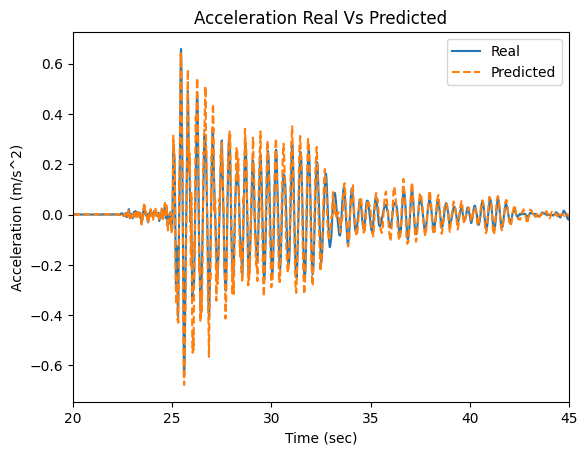

In [16]:
pred_acc = linear_pred[2, : , 0]
real_acc = linear_y_val.numpy()[2, : , 0]

plot_data(real_acc[:11000], pred_acc[:11000], "Acceleration Real Vs Predicted", "Time (sec)", "Acceleration (m/s^2)", xlim1=20, xlim2=45)

# Nonlinear data

In [17]:
nonlinear_dataset = Dataset("/content/drive/MyDrive/Fall 2023/Deep Learning/Final/Data/all_eq_processed_data_ID_m_SDOF_nonlinear_v003.pickle",NormalizationOption.ScaleShiftAll)

In [18]:
nonlinear_dataset.print_stats()

dataset.max_timesteps      26799
dataset.min_timesteps      11201
dataset.max_abs_acc_input  0.9249152239983484
dataset.max_abs_acc_output 2.388819770954014
dataset.max_abs_vel_output 0.2965077324958503
dataset.max_abs_dsp_output 0.04911199321384019
dataset.max_acc_input      0.9249152239983484
dataset.max_acc_output     2.388819770954014
dataset.max_vel_output     0.26635628566020086
dataset.max_dsp_output     0.033717489781566023
dataset.min_acc_input      -0.772271468355947
dataset.min_acc_output     -1.9476202152885298
dataset.min_vel_output     -0.2965077324958503
dataset.min_dsp_output     -0.04911199321384019
dataset.max_abs_all        2.388819770954014
dataset.max_all            2.388819770954014
dataset.min_all            -1.9476202152885298


In [19]:
nonlinear_x_train, nonlinear_x_val, nonlinear_y_train, nonlinear_y_val = nonlinear_dataset.split_data()

In [20]:
NUM_FEATURES = 1
NUM_CLASSES = 1
NUM_FILTERS = 128
KERNEL_SIZE = 9
PADDING = "causal" # Causal for causal network, same for non causal,
DILATIONS = [1, 2, 4, 8, 16, 32, 64, 128]

In [21]:
nonlinear_model = tf.keras.models.Sequential([
    tf.keras.layers.Masking(mask_value=0., input_shape=(nonlinear_dataset.max_timesteps, NUM_FEATURES)),
    TCN(
      nb_filters=NUM_FILTERS,
      kernel_size=KERNEL_SIZE,
      dilations=DILATIONS,
      padding=PADDING,
      return_sequences=True
    ),
    tf.keras.layers.Dense(NUM_CLASSES, activation="tanh")
])
nonlinear_model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer="adam")

In [22]:
nonlinear_model.fit(
    nonlinear_x_train, nonlinear_y_train,
    batch_size=BATCH_SIZE,
    validation_data=(nonlinear_x_val, nonlinear_y_val),
    validation_batch_size=VALIDATION_BATCH_SIZE,
    epochs=50
)

Epoch 1/50
8/8 [==============================] - 17s 561ms/step - loss: 0.1029 - val_loss: 0.0090
Epoch 2/50
8/8 [==============================] - 4s 487ms/step - loss: 0.0069 - val_loss: 0.0015
Epoch 3/50
8/8 [==============================] - 4s 566ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 4/50
8/8 [==============================] - 4s 486ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 5/50
8/8 [==============================] - 4s 481ms/step - loss: 0.0072 - val_loss: 0.0034
Epoch 6/50
8/8 [==============================] - 4s 482ms/step - loss: 0.0048 - val_loss: 7.0175e-04
Epoch 7/50
8/8 [==============================] - 4s 487ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 8/50
8/8 [==============================] - 4s 479ms/step - loss: 0.0017 - val_loss: 6.3706e-04
Epoch 9/50
8/8 [==============================] - 4s 478ms/step - loss: 0.0020 - val_loss: 5.8935e-04
Epoch 10/50
8/8 [==============================] - 4s 484ms/step - loss: 0.0015 - val_loss: 6.5187e-04
Ep

In [23]:
nonlinear_pred = nonlinear_model.predict(nonlinear_x_val)

1/1 [==============================] - 7s 7s/step


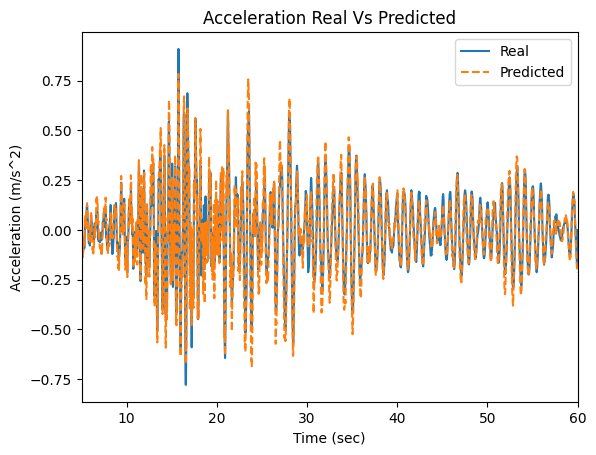

In [24]:
pred_acc = nonlinear_pred[3, : , 0]
real_acc = nonlinear_y_val.numpy()[3, : , 0]

plot_data(real_acc, pred_acc, "Acceleration Real Vs Predicted", "Time (sec)", "Acceleration (m/s^2)", xlim1=5, xlim2=60)

# Evaluation

## Correlation Coefficients

In [25]:
from scipy.stats import pearsonr

In [26]:
def correlation_coeff(real, predicted):
  coeffs = np.zeros(real.shape[0])

  for i in range(real.shape[0]):
    coeffs[i] = pearsonr(real[i, 4000:11000, 0], predicted[i, 4000:11000, 0]).statistic

  return coeffs

In [27]:
linear_corr = correlation_coeff(real=linear_y_val.numpy(), predicted=linear_pred)
nonlinear_corr = correlation_coeff(real=nonlinear_y_val.numpy(), predicted=nonlinear_pred)

In [28]:
data = {
    "Linear Correlation Coefficients": linear_corr,
    "Nonlinear Correlation Coefficients": nonlinear_corr
}

df = pd.DataFrame(data)
print(df)

   Linear Correlation Coefficients  Nonlinear Correlation Coefficients
0                         0.942596                            0.344755
1                         0.835932                            0.441655
2                         0.956709                            0.715355
3                         0.927174                            0.955591
4                         0.930227                            0.353629
5                         0.954520                            0.607042
6                         0.951295                            0.446214
7                         0.946101                            0.614712


## Probability Distribution of Errors

In [29]:
def errors(real, predicted):
  error = np.zeros((real.shape[0], real.shape[1]))

  for i in range(real.shape[0]):
    error[i, :] = (np.abs(real[i, :, 0] - predicted[i, :, 0])) / (np.max(np.abs(real[i, :, 0])))

  return error

In [30]:
linear_error = errors(real=linear_y_val.numpy(), predicted=linear_pred)
nonlinear_error = errors(real=nonlinear_y_val.numpy(), predicted=nonlinear_pred)

In [31]:
def plot_subplots(sequence1, sequence2, title1, title2, xlabel, ylabel, xlim1, xlim2):
  x = np.arange(start=0, stop=len(sequence1), step=1) * 0.005 # time step is 0.005

  f, axs = plt.subplots(1, 2, figsize=(10, 10))

  axs[0].plot(x, sequence1)
  axs[0].set_title(title1)
  axs[0].set_xlabel(xlabel)
  axs[0].set_ylabel(ylabel)
  axs[0].set_ylim(0, 100)
  axs[0].set_xlim(xlim1, xlim2)
  axs[1].plot(x, sequence2)
  axs[1].set_title(title2)
  axs[1].set_xlabel(xlabel)
  axs[1].set_ylim(0, 100)
  axs[1].set_xlim(xlim1, xlim2)
  plt.show()

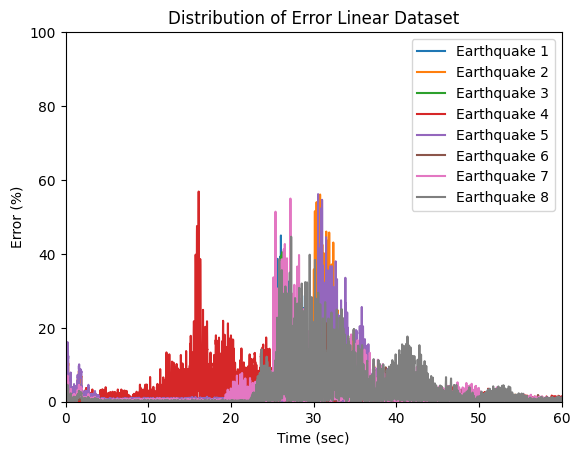

In [32]:
for i in range(8):
  plt.plot(np.arange(start=0, stop=linear_error.shape[1], step=1) * 0.005, linear_error[i, :] * 100, label=f"Earthquake {i + 1}")

plt.xlim([0, 60])
plt.ylim(0, 100)
plt.xlabel("Time (sec)")
plt.ylabel("Error (%)")
plt.title("Distribution of Error Linear Dataset")
plt.legend()
plt.show()

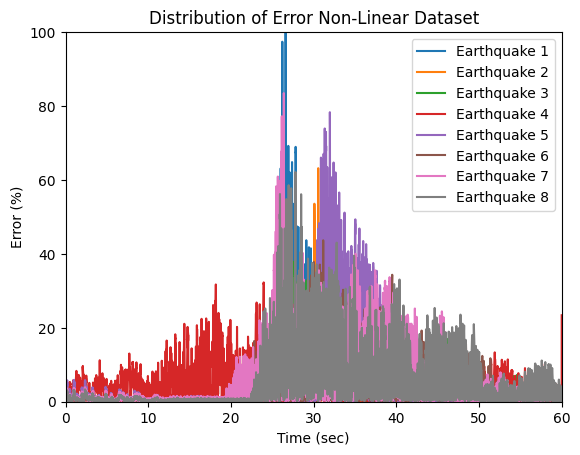

In [33]:
for i in range(8):
  plt.plot(np.arange(start=0, stop=linear_error.shape[1], step=1) * 0.005, nonlinear_error[i, :] * 100, label=f"Earthquake {i + 1}")

plt.xlim([0, 60])
plt.ylim(0, 100)
plt.xlabel("Time (sec)")
plt.ylabel("Error (%)")
plt.title("Distribution of Error Non-Linear Dataset")
plt.legend()
plt.show()

In [34]:
def peak_error(real, predicted):
  error = np.zeros(real.shape[0])

  for i in range(real.shape[0]):
    error[i] = (np.abs(np.max(predicted[i, :, 0]) - np.max(real[i, :, 0]))) / np.max(np.abs(real[i, :, 0]))

  return error

In [35]:
linear_error_peak = peak_error(real=linear_y_val.numpy(), predicted=linear_pred)
nonlinear_error_peak = peak_error(real=nonlinear_y_val.numpy(), predicted=nonlinear_pred)

In [36]:
def plot_peak_error(sequence1, sequence2, title1, title2, xlabel, ylabel, xlim1, xlim2):
  f, axs = plt.subplots(1, 2, figsize=(10, 10))

  axs[0].plot(sequence1)
  axs[0].set_title(title1)
  axs[0].set_xlabel(xlabel)
  axs[0].set_ylabel(ylabel)
  axs[0].set_ylim(0, 100)
  axs[0].set_xlim(xlim1, xlim2)
  axs[1].plot(sequence2)
  axs[1].set_title(title2)
  axs[1].set_xlabel(xlabel)
  axs[1].set_ylim(0, 100)
  axs[1].set_xlim(xlim1, xlim2)
  plt.show()

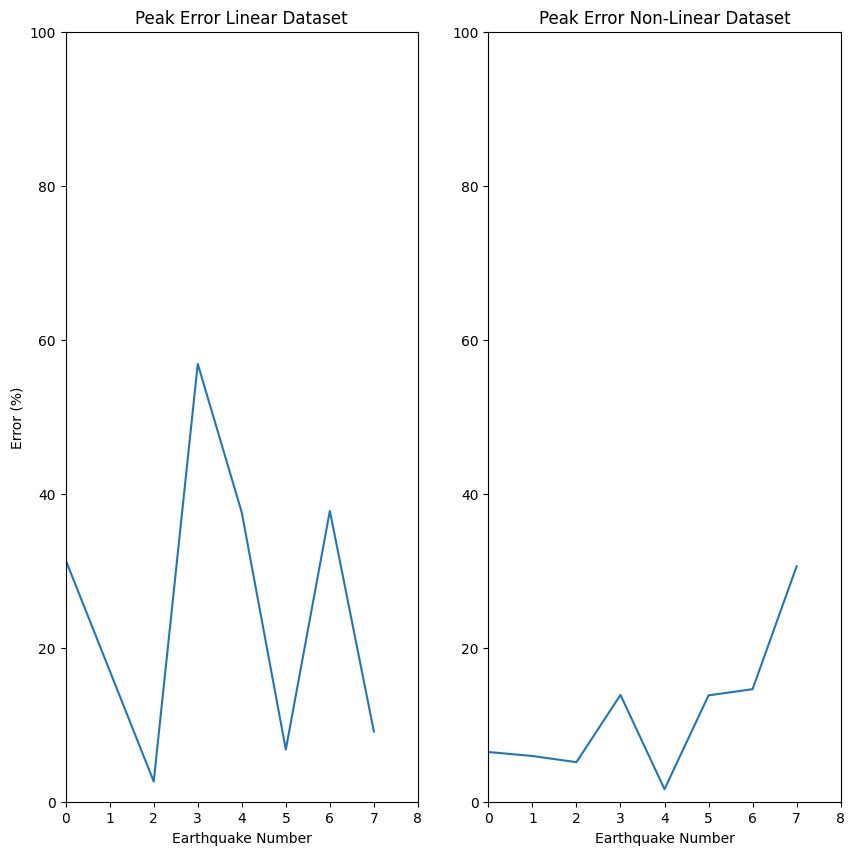

In [37]:
plot_peak_error(linear_error_peak* 100, nonlinear_error_peak*100, "Peak Error Linear Dataset", "Peak Error Non-Linear Dataset", "Earthquake Number", "Error (%)", 0, 8)

In [38]:
def cav(data):
  sum = np.zeros((data.shape[0], data.shape[1]))

  for i in range(data.shape[0]):
    sum[i, :] = np.cumsum(np.abs(data[i, :])) * 0.005

  return sum

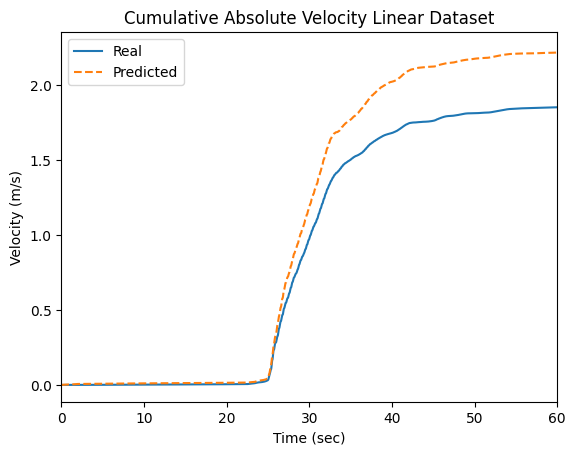

In [39]:
cav_linear_real = cav(linear_y_val.numpy())
cav_linear_pred = cav(linear_pred)
plot_data(cav_linear_real[2], cav_linear_pred[2], "Cumulative Absolute Velocity Linear Dataset", "Time (sec)", "Velocity (m/s)", 0, 60)

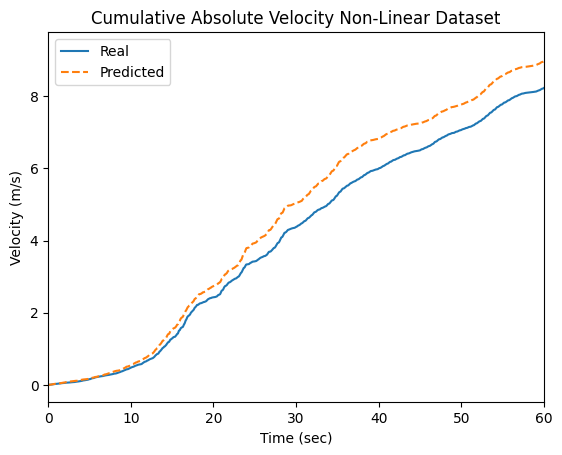

In [40]:
cav_nonlinear_real = cav(nonlinear_y_val.numpy())
cav_nonlinear_pred = cav(nonlinear_pred)
plot_data(cav_nonlinear_real[3], cav_nonlinear_pred[3], "Cumulative Absolute Velocity Non-Linear Dataset", "Time (sec)", "Velocity (m/s)", 0, 60)